In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from os import listdir
from os.path import isfile, join

from PIL import Image

from skimage import img_as_ubyte, img_as_float
from skimage.io import imread, imsave

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# A bunch of utility functions

def show_array_images(images, title = ''):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    
    plt.suptitle(title)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
def imgshow(array_image):
    """ Show one array image as uint8 and remove axis labels """
    sqrtimg = int(np.ceil(np.sqrt(array_image.shape[0])))
    imshow_noax(array_image.reshape([sqrtimg,sqrtimg]), normalize=True)

def array_to_image(array):
    sqrtimg = int(np.ceil(np.sqrt(array.shape[0])))
    x = np.array(array.reshape([sqrtimg,sqrtimg]))
    return x
    
def image_to_array(image):
    l = image.shape[0]*image.shape[1]
    x = np.array(image.reshape([l]))
    return x

def center_square(array_image, square_h, square_w, pixel_value = 0.3):
    img = array_to_image(array_image)
    h, w = img.shape                     
    j = int(round((h - square_h)/2.))
    i = int(round((w - square_w)/2.))
    img[j:j+square_h, i:i+square_w] = pixel_value
    img = image_to_array(img)
    return img

def mask_images(array_images, masktype, *args):
    """ Retruns an array of image and masked image pairs """
    masked_images = []
    for array_image in array_images:
        if masktype == 'square':
            masked = center_square(array_image,*args)
        masked_images.append(array_image)
        masked_images.append(masked)
    return np.array(masked_images)

#utility functions for GANs

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

from itertools import izip

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return izip(a, a)

def rescale(a):
    return (a - np.min(a))/(np.max(a)-np.min(a))

def postporcess(mean_anomaly, ksize=3, threshold = 0.49):
    ker = 0.25*np.ones((ksize,ksize))
    a = convolve2d(array_to_image(mean_anomaly), ker, mode='same', boundary='symm')
    a = rescale(a)
    a = np.where(a >= threshold, 1,0)
    predicted_mask = image_to_array(a)
    return predicted_mask

def int_over_union(predicted, ground_truth):
    intersection = np.sum(np.multiply(predicted,ground_truth))
    union = predicted + ground_truth
    union = np.sum(np.clip(union,0,1))
    return intersection/union

def show_images(images):
    n = int(np.ceil(np.sqrt(len(images))))
    fig = plt.figure(figsize=(n, n))
    gs = gridspec.GridSpec(n, n)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
    
def inverse_transform(images):
    return (images+1.)/2.

def transform(image, npx=64, is_crop=True):
    # npx : # of pixels width/height of image
    if is_crop:
        cropped_image = center_crop(image, npx)
    else:
        cropped_image = image
    return np.array(cropped_image)/127.5 - 1

def read_img_patches(path,name):
    patches = []
    for i in range(764):
        img = Image.open(path+'Normal/normal_patches/'+name+'-'+str(i)+'.png')
        patches.append(np.array(img))
    return patches

def read_full_img(path, n = 100):
    image_names = [f for f in listdir(path) if isfile(join(path, f))]
    image_names.remove('Thumbs.db')
    image_names.sort()
    images = []
    for name in image_names[0:n]:
        img = imread(path+name)
        img = img_as_float(img)
        images.append(img)
    return images

In [3]:
#Restore a model
tf.reset_default_graph()
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('../../work/slides/dcgan-completion.tensorflow/checkpoint/DCGAN.model-59502.meta')
saver.restore(sess,tf.train.latest_checkpoint('../../work/slides/dcgan-completion.tensorflow/checkpoint/'))

INFO:tensorflow:Restoring parameters from ../../work/slides/dcgan-completion.tensorflow/checkpoint/DCGAN.model-59502


In [11]:
graph = tf.get_default_graph()

#input of first operation we want to restore: generator = genertor input
gi = graph.get_tensor_by_name("z:0")

#output of last operation we want to restore: discriminator = generator output
go = graph.get_tensor_by_name("generator/Tanh:0")

#is training placeholder
it = graph.get_tensor_by_name("is_training:0")

#Discriminator feature layer output
dfl = graph.get_tensor_by_name('discriminator/lrelu_3/add:0')

#Discriminator input
di = graph.get_tensor_by_name("real_images:0")

In [12]:
def features(image):
    features = sess.run(dfl,feed_dict={di: np.reshape(image,[-1,64,64,3]), it:False})
    return np.reshape(features, [-1,8192])

def generator(z,gi,go):
    G_sample = sess.run(go, feed_dict={gi: z, it:False})
    return G_sample

In [13]:
#Sample from generator for ICIAR
# number of images for each batch
sample_size = 64
# our noise dimension
z_dim = 100
z = np.random.uniform(-1, 1, size=(sample_size , z_dim))
sample_out = sess.run(go, feed_dict={gi: z, it:False})

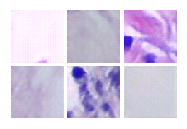

In [14]:
show_images(inverse_transform(sample_out[0:6]))

In [29]:
# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
#input dimensions
image_shape = go.shape[1:].as_list()


#Get loss
alpha = 0.99
beta = 1e-3

with graph.as_default():
    images = tf.placeholder(tf.float32,image_shape, name='images') 
    xf = tf.placeholder(tf.float32,[1,8192], name='x_features') 
    #define loss
    L2_loss = tf.nn.l2_loss(go-images)
    L2_loss = tf.norm(go-images)
    perceptual_loss = tf.nn.l2_loss(tf.reshape(dfl,[-1,8192])-xf)
    #perceptual_loss = L2_loss
    z_loss = alpha*L2_loss + (1-alpha)*beta*perceptual_loss
    z_grads = tf.gradients(z_loss, gi) 

In [39]:
def z_search(z, x, real_x, features, alpha,beta, nIter = 3000, v = 0, momentum = 0.9, adam = False, nesterov = False,
             lr = 0.001, print_every = 250, show_every = 500, multiple_images = False, decay_every  = 1000, 
             m = 0):
    
    loss_history = []
    show_history = []
    
    for i in range(nIter):
        out_vars = [L2_loss, perceptual_loss, z_loss, z_grads, go]
        in_dict = {gi: z, images: x, it: False, xf: features, di: generator(z,gi,go)}

        loss1, loss2, loss, grad, imout = sess.run(out_vars, feed_dict=in_dict)
        

        
        #step decay
        if (i % decay_every == 0):
            lr = 0.5*lr
            
        if nesterov:    
            #Nesterov
            v_prev = np.copy(v)
            v = momentum*v - lr*grad[0]
            z += (-momentum * v_prev +
                       (1 + momentum) * v)
            z = np.clip(z, -1, 1)
        
        if adam:
            eps = 1e-8
            beta1 = 0.9
            beta2 = 0.999
            # Adam t is your iteration counter going from 1 to infinity
            dx = grad[0]
            t = i+1
            m = beta1*m + (1-beta1)*dx
            mt = m / (1-beta1**t)
            v = beta2*v + (1-beta2)*(dx**2)
            vt = v / (1-beta2**t)
            z += - lr * mt / (np.sqrt(vt) + eps)
        
        
        
        #Mean image
        mean = np.mean(imout, axis = 0)
        mean = mean
        
        if not(multiple_images):
            if (i % print_every == 0):
                print('Iteration {}, Loss: {}, l2: {}, pl:{}'.format(i, loss, alpha*loss1, (1-alpha)*beta*loss2))
        
            

            if (i % show_every == 0):
                show = inverse_transform(np.array([real_x,x,imout[0],mean]))
                show_images(show)
                plt.show()

        else:
            if (i % show_every == 0):
                show = inverse_transform(np.array([real_x,x,imout[0],mean]))
                show_images(show)
                plt.show()
            
        loss_history.append(loss)
        
    if not(multiple_images):     
        #final print
        print('Final images:')
        show = inverse_transform(np.array([real_x,x,imout[0],mean]))
        show_images(show)
        plt.show()
    
    return imout, loss_history, mean

Iteration 0, Loss: 368.252380371, l2: 365.735783386, pl:2.51660640625


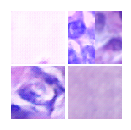

Iteration 250, Loss: 206.189910889, l2: 204.739616547, pl:1.4502828125
Iteration 500, Loss: 201.86819458, l2: 200.391417389, pl:1.4767775


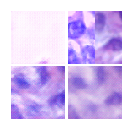

Iteration 750, Loss: 197.621276855, l2: 196.11205719, pl:1.5092165625
Iteration 1000, Loss: 198.321075439, l2: 196.794781952, pl:1.52629328125


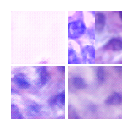

Iteration 1250, Loss: 196.22958374, l2: 194.687164764, pl:1.5424240625
Iteration 1500, Loss: 193.331008911, l2: 191.807590485, pl:1.52342484375


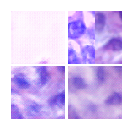

Iteration 1750, Loss: 188.81690979, l2: 187.335852814, pl:1.4810509375
Final images:


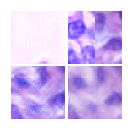

In [143]:
#Search in latent space
#z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=1))
z = np.random.uniform(-1, 1, size=(sample_size , z_dim))

real_x = sample_out[0]
#x = preprocess_img(patch)
x = preprocess_img(hybrid)
#x = aux
fts = features(x)

imout,loss_history, mean = z_search(z, x,real_x,fts, alpha, beta, nIter=2000, show_every=500, momentum = 0.99,
                                    print_every=250, lr = 1e-1, decay_every = 1200, adam = False, nesterov = True)

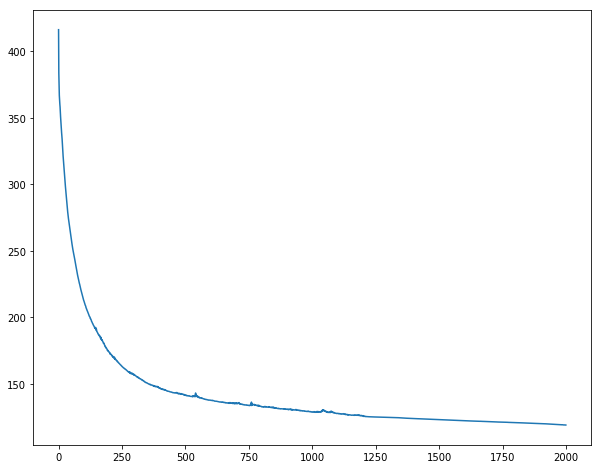

In [33]:
plt.plot(loss_history)
plt.show()

In [4]:
#Read normal patches
#Read patches from one image
path = '../../work/slides/ICIAR2018_BACH_Challenge/Photos/'
name = 'n006'
patches = read_img_patches(path,name)
len(patches)

764

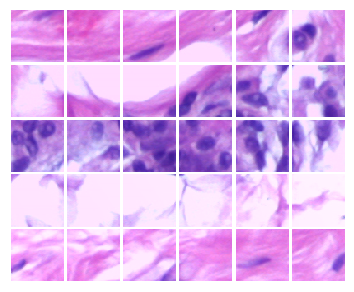

In [58]:
show_images(patches[200:230])

In [102]:
aux = transform(patches[153], is_crop =False)

In [63]:
#Look at pathology images
invasive_path = '../../work/slides/ICIAR2018_BACH_Challenge/Photos/Invasive/'

In [64]:
#Invasive images
invasive_images = read_full_img(invasive_path, n = 10)
print(len(invasive_images))

10


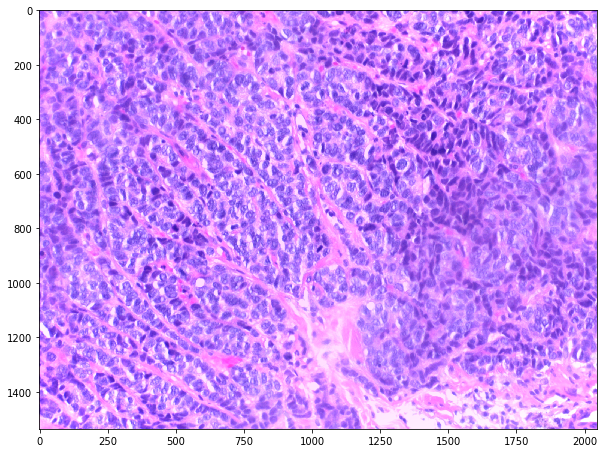

In [65]:
plt.imshow(invasive_images[4])

In [179]:
#extract a square
img = invasive_images[8]
patch = np.zeros(64)
h, w, c = img.shape                     
j = int(round((h - 64)/2.))
i = int(round((w - 64)/2.))
#patch = np.ones([64,64,3])
patch = img[j:j+64, i:i+64,:]
patch.shape

(64, 64, 3)

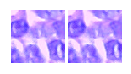

In [180]:
show = np.array([patch,patch])
show_images(show)

In [211]:
#fusion composed image
aux = transform(patches[213], is_crop =False)
img2 = np.copy(inverse_transform(sample_out[9]))
img1 = np.copy(patch)
hybrid = img1
hybrid[0:64, 32:64,:] = img2[0:64, 32:64,:]

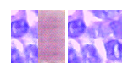

In [212]:
show = np.array([hybrid,patch])
show_images(show)

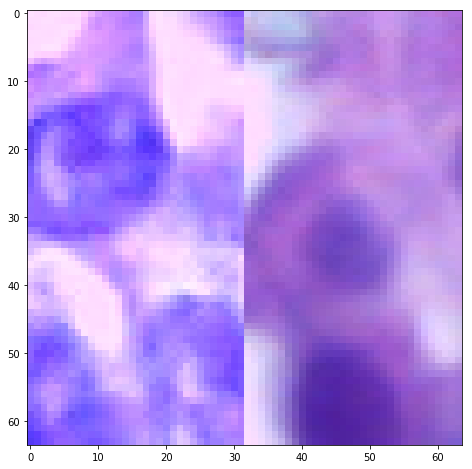

In [186]:
plt.imshow(hybrid)

In [138]:
#anomal density maps
mean_anomaly = np.mean(np.abs(deprocess_img(imout)-deprocess_img(x)), axis=0)

600.619601711


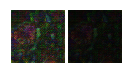

In [62]:
#normal anomaly
print(np.sum(mean_anomaly))
show = np.array([3*mean_anomaly,mean_anomaly])
show_images(show)

1013.00946752


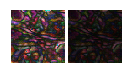

In [81]:
#pathological anomaly
print(np.sum(mean_anomaly))
show = np.array([3*mean_anomaly,mean_anomaly])
show_images(show)

837.994528054


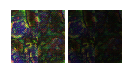

In [213]:
#composed anomaly
print(np.sum(mean_anomaly))
show = np.array([3*mean_anomaly,mean_anomaly])
show_images(show)